# Packages

In [4]:
## Verify that pytorch-geometric is correctly installed
import torch_geometric
import torch
import torch_sparse
from torch_geometric.nn import MessagePassing

import numpy as np
import os
import requests
import json

from tqdm import tqdm

import pandas as pd
import matplotlib.pyplot as plt

import esm

# We use the pretrained model from esm, to get latent variables for the graph structure
model_esm_if1, alphabet = esm.pretrained.esm_if1_gvp4_t16_142M_UR50()
# use eval mode for deterministic output e.g. without random dropout
model_esm_if1 = model_esm_if1.eval()

c:\Users\jonas\anaconda3\envs\DeepLearningProject\lib\site-packages\esm\pretrained.py:216: UserWarning: Regression weights not found, predicting contacts will not produce correct results.
  "Regression weights not found, predicting contacts will not produce correct results."


In [5]:
# Helper function, given a protein ID, use the alpha fold downloaded struture and return latent variables from esm structure
def PretrainedEncoder(proteinID):
  fpath = '/content/drive/MyDrive/AlphaFoldDB/' + proteinID + '.pdb' # .pdb format is also acceptable
  chain_ids = ['A']
  structure = esm.inverse_folding.util.load_structure(fpath, chain_ids)

  coords, _ = esm.inverse_folding.multichain_util.extract_coords_from_complex(structure)

  target_chain_id = 'A'     # Always use chain "A", as we only have 1 protein (chain)
  rep = esm.inverse_folding.multichain_util.get_encoder_output_for_complex(model_esm_if1, alphabet, coords, target_chain_id)
  return rep.detach()

labels_map = {
  "B": torch.tensor([1,0,0,0,0,0]),
  "I": torch.tensor([0,1,0,0,0,0]),
  "M": torch.tensor([0,0,1,0,0,0]),
  "O": torch.tensor([0,0,0,1,0,0]),
  "P": torch.tensor([0,0,0,0,1,0]),
  "S": torch.tensor([0,0,0,0,0,1]),
}

# Get proteins for data set

In [6]:
FileObj = open("DeepTMHMM.partitions.json","r")
CVs = json.loads(FileObj.read())

# Unique labels
Unique = []
for key in CVs.keys():
  cv = CVs[key]
  for prot in cv:
    Unique += list(set(prot["labels"]))

labels = np.unique(Unique)
print(labels)

['B' 'I' 'M' 'O' 'P' 'S']


In [7]:
AlphaFoldResults = [f[:-4] for f in os.listdir("AlphaFoldDB") if (os.path.isfile("AlphaFoldDB/" + f) & f.__contains__(".pdb") )]

In [8]:
# The following 3 proteins did not match between AlphaFold and the supplied JSON. Running the code to find these took a very long time.
BlackListProteins = ["Q841A2", "D6R8X8", "Q8I2A6"]

# These were in the json with data trained on, but not in crossval results (https://biolib-public-assets.s3.eu-west-1.amazonaws.com/deeptmhmm/DeepTMHMM.crossval.top)
BlackListProteins += ["P02930", "A1JUB7"]

proteinIDs = []
AlphaFoldResultsSet = set(AlphaFoldResults)


# Get proteins where:
#   Is in AlphaFold
#   Is atmost 1500 amino acids long
#   Is not in blacklist (AlphaFold and JSON sequence does not match)
with open("DeepTMHMM.partitions.json", "r") as FileObj:
    CVs = json.loads(FileObj.read())
    for cv in CVs.keys():
        cvProteins = CVs[cv]
        for idx, protein in enumerate(cvProteins):
            if protein["sequence"].__len__() > 1_500:
                continue
            if protein["id"] in BlackListProteins:
                continue
            if protein["id"] in AlphaFoldResultsSet:
                proteinIDs += [
                    [
                        protein["id"],
                        protein,
                        protein["sequence"],
                        protein["labels"],
                        cv,
                        idx,
                    ]
                ]


columns = ["proteinID", "protein", "sequence", "labels", "CV", "index"]
proteinMap = pd.DataFrame(proteinIDs, columns=columns)
proteinMap.index = proteinMap["proteinID"].values

In [9]:
proteinMap


,proteinID,protein,sequence,labels,CV,index
P10384,P10384,"{'id': 'P10384', 'sequence': 'MSQKTLFTKSALAVAV...",MSQKTLFTKSALAVAVALISTQAWSAGFQLNEFSSSGLGRAYSGEG...,SSSSSSSSSSSSSSSSSSSSSSSSSPPPPPPPPPPPPPPPPPPPPP...,cv0,0
P0ABU7,P0ABU7,"{'id': 'P0ABU7', 'sequence': 'MGNNLMQTDLSVWGMY...",MGNNLMQTDLSVWGMYQHADIVVKCVMIGLILASVVTWAIFFSKSV...,OOOOOOOOOOOOOOOOOOOOOOMMMMMMMMMMMMMMMMMMMMMIII...,cv0,1
Q55210,Q55210,"{'id': 'Q55210', 'sequence': 'MNKILGIDPLKKFIFG...",MNKILGIDPLKKFIFGISAFVLLFWQLNVGAANATALREVDRTVNL...,SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSOOOOOOOOOOOO...,cv0,2
Q5XKL5,Q5XKL5,"{'id': 'Q5XKL5', 'sequence': 'MARCGEGSAAPMVLLG...",MARCGEGSAAPMVLLGSAGVCSKGLQRKGPCERRRLKATVSEQLSQ...,IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII...,cv0,3
Q9KDP2,Q9KDP2,"{'id': 'Q9KDP2', 'sequence': 'MNYMKRRLLLFAGILL...",MNYMKRRLLLFAGILLLVALAGCSTTDPITSESEGIWNHFFVYPMS...,SSSSSSSSSSSSSSSSSSSSSSOOOOOOOOOOOOOOOOOOOOOOOO...,cv0,4
...,...,...,...,...,...,...
P43457,P43457,"{'id': 'P43457', 'sequence': 'MMDYLITQNGGMVFAV...",MMDYLITQNGGMVFAVLAMATATIFSGIGSAKGVGMTGEAAAALTT...,OOOOOOOOOOOOOOOMMMMMMMMMMMMMMMMMMMMIIIIIIIIIII...,cv4,709
O15553,O15553,"{'id': 'O15553', 'sequence': 'MAKTPSDHLLSTLEEL...",MAKTPSDHLLSTLEELVPYDFEKFKFKLQNTSVQKEHSRIPRSQIQ...,IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII...,cv4,710
O94278,O94278,"{'id': 'O94278', 'sequence': 'MCPSDFSSRSLFLEAK...",MCPSDFSSRSLFLEAKEEEYKQRRRVPLDSRRRVRRACLSCRAKKI...,IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII...,cv4,711
P15450,P15450,"{'id': 'P15450', 'sequence': 'MKVVIFIFALLATICA...",MKVVIFIFALLATICAAFAYVPLPNVPQPGRRPFPTFPGQGPFNPK...,SSSSSSSSSSSSSSSSSSSOOOOOOOOOOOOOOOOOOOOOOOOOOO...,cv4,712


['B' 'I' 'M' 'O' 'P' 'S']


,proteinID
,count
CV,
cv0,691
cv1,690
cv2,686
cv3,678
cv4,685


min protein length 50
max protein length 1500


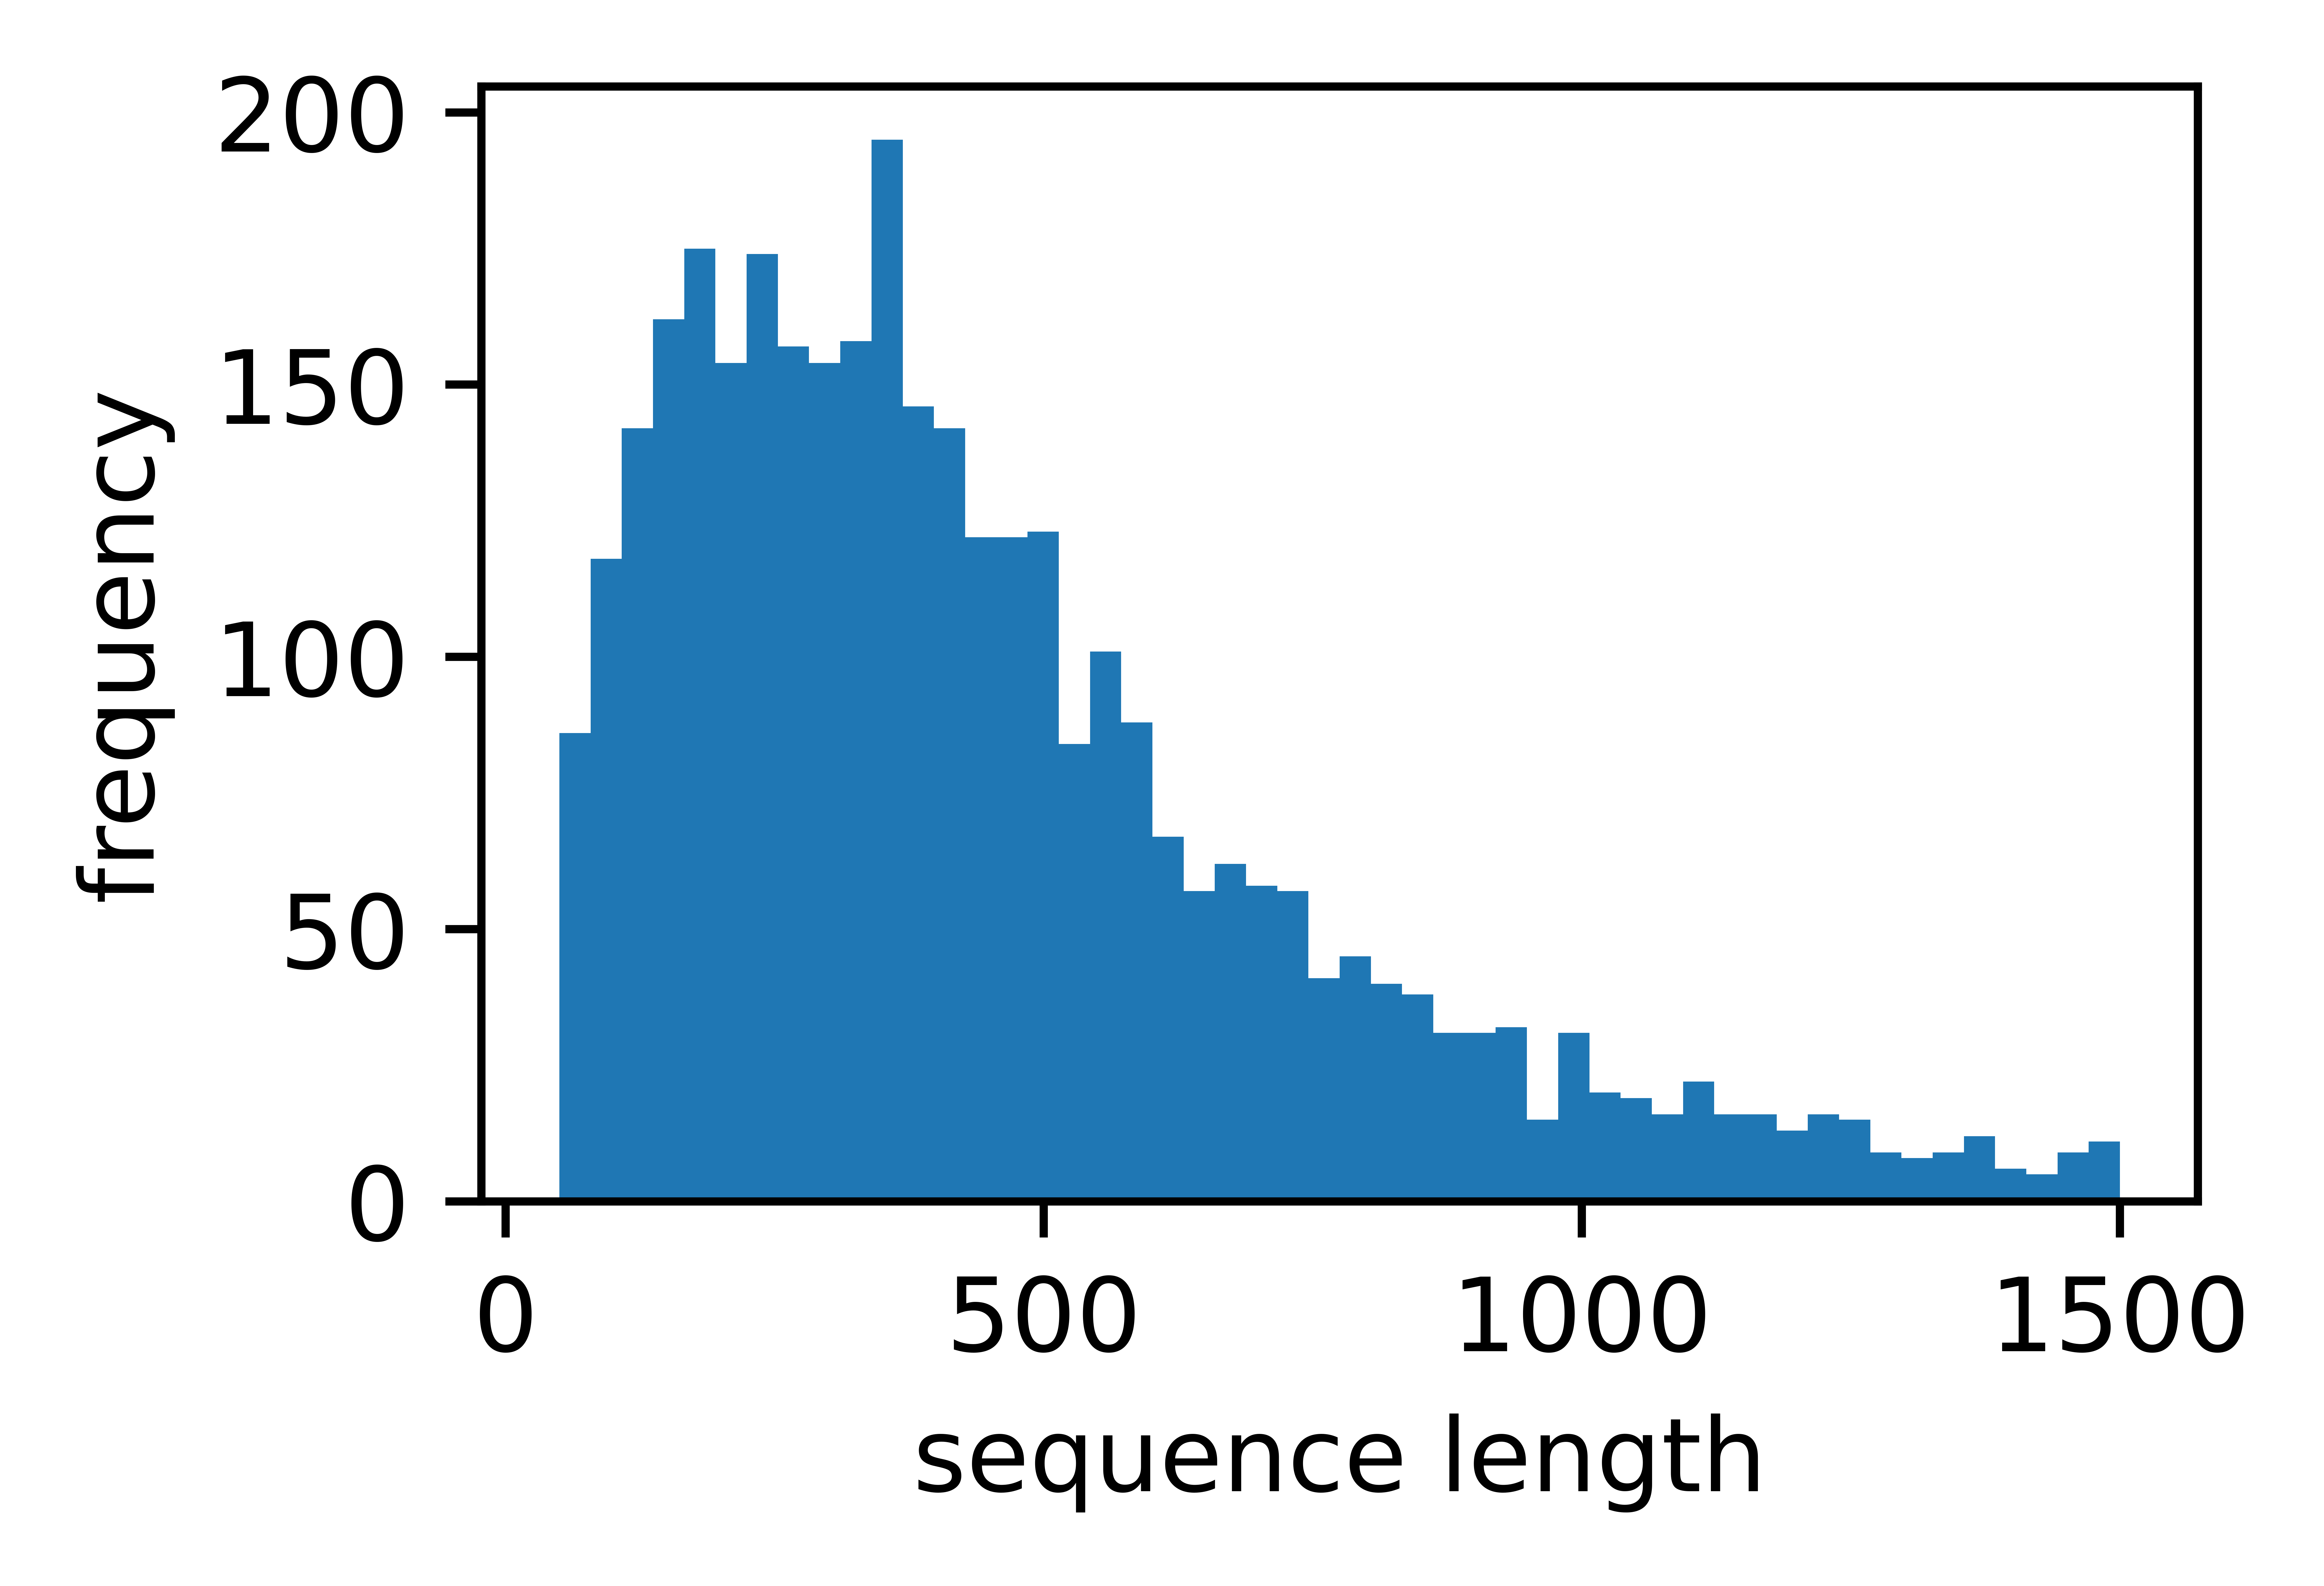

In [14]:
# Unique labels
Unique = []
for key in CVs.keys():
  cv = CVs[key]
  for prot in cv:
    Unique += list(set(prot["labels"]))

print(np.unique(Unique))

# Distirbution of cv counts
display(proteinMap[["proteinID","CV"]].groupby("CV").agg(['count']))

# Distribution on lengths
Lengths = []
for idx, protein in proteinMap.iterrows():
  Lengths += [protein.protein["sequence"].__len__()]


print("min protein length", np.min(Lengths))
print("max protein length",np.max(Lengths))

plt.figure(dpi=2500, figsize=(3,2))
plt.hist(Lengths, bins = 50)
plt.xlabel("sequence length")
plt.ylabel("frequency")
plt.show()

In [ ]:
proteinMap.protein

P10384    {'id': 'P10384', 'sequence': 'MSQKTLFTKSALAVAV...
P0ABU7    {'id': 'P0ABU7', 'sequence': 'MGNNLMQTDLSVWGMY...
Q55210    {'id': 'Q55210', 'sequence': 'MNKILGIDPLKKFIFG...
Q5XKL5    {'id': 'Q5XKL5', 'sequence': 'MARCGEGSAAPMVLLG...
Q9KDP2    {'id': 'Q9KDP2', 'sequence': 'MNYMKRRLLLFAGILL...
                                ...                        
P43457    {'id': 'P43457', 'sequence': 'MMDYLITQNGGMVFAV...
O15553    {'id': 'O15553', 'sequence': 'MAKTPSDHLLSTLEEL...
O94278    {'id': 'O94278', 'sequence': 'MCPSDFSSRSLFLEAK...
P15450    {'id': 'P15450', 'sequence': 'MKVVIFIFALLATICA...
O74464    {'id': 'O74464', 'sequence': 'MKYINQFMKISKGFLV...
Name: protein, Length: 3432, dtype: object

In [ ]:
list(proteinMap.index)

['P10384',
 'P0ABU7',
 'Q55210',
 'Q5XKL5',
 'Q9KDP2',
 'Q9CC87',
 'Q7TQM5',
 'Q2YDF6',
 'P10163',
 'Q12286',
 'Q0P9C4',
 'Q9SIW2',
 'P10257',
 'Q9USW9',
 'P50580',
 'Q9UHW9',
 'Q9MV14',
 'Q25255',
 'Q9US51',
 'P17558',
 'O31284',
 'Q9VSK8',
 'P28611',
 'F4JN26',
 'Q8N474',
 'P07305',
 'Q8L719',
 'P10745',
 'K4D422',
 'P0AG96',
 'Q01172',
 'Q18412',
 'P38777',
 'O42914',
 'P49146',
 'Q68XS6',
 'Q5FBB7',
 'Q62414',
 'Q10Q07',
 'P21554',
 'Q9UU87',
 'E9K9Z1',
 'P40518',
 'Q12287',
 'Q32MW3',
 'B3U538',
 'P54498',
 'P9WG65',
 'Q06506',
 'Q8IWU4',
 'C1B1D9',
 'Q9D4W2',
 'Q08561',
 'A0A0B9X9I7',
 'Q97WX4',
 'Q7CGI0',
 'P87176',
 'Q96FM1',
 'Q5A5Q6',
 'C7G3K3',
 'P21826',
 'Q9LU68',
 'P0AC98',
 'O34344',
 'P09038',
 'O14131',
 'Q9FKB3',
 'P13385',
 'Q9H293',
 'C4IN73',
 'P01019',
 'O83077',
 'Q54GH3',
 'P52927',
 'P42586',
 'P21978',
 'Q9EYW6',
 'P38852',
 'P37648',
 'P0A8Q0',
 'Q9HDZ6',
 'Q5E2P0',
 'Q10424',
 'P15289',
 'Q2V3L3',
 'P38439',
 'Q10356',
 'P51688',
 'O74544',
 'Q15722',
 'P550

In [ ]:
import pickle

with open('ProteinsUsed.txt', 'wb') as fp:
    pickle.dump(list(proteinMap.index), fp)
    # np.savetxt("ProteinsUsed.txt",list(proteinMap.index),delimiter=',');

## Find proteins where AlphaFold sequence does not match sequence in supplied JSON

In [ ]:
# from graphein.protein.config import ProteinGraphConfig
# from graphein.protein.graphs import construct_graph

# config = ProteinGraphConfig()

# ProteinAlphaFoldMissMatch = []

# for proteinID in tqdm(AlphaFoldResults):
#   path = '/content/drive/MyDrive/AlphaFoldDB/' + proteinID + '.pdb'
#   g = construct_graph(config=config, path=path)
#   if (g.graph['sequence_A'] != proteinMap.loc[proteinID].protein["sequence"]):
#     ProteinAlphaFoldMissMatch += [proteinID]

In [ ]:
# ProteinAlphaFoldMissMatch

### Inspection of missmatches

In [ ]:
# AlphaFoldWrongSequences = []
# JSONSequence = []

# for proteinID in tqdm(ProteinAlphaFoldMissMatch):
#   path = '/content/drive/MyDrive/AlphaFoldDB/' + proteinID + '.pdb'
#   g = construct_graph(config=config, path=path)
#   AlphaFoldWrongSequences += [g.graph['sequence_A']]
#   JSONSequence += [proteinMap.loc[proteinID].protein["sequence"]]

In [ ]:
# for i in range(JSONSequence.__len__()):
#   print(AlphaFoldWrongSequences[i])
#   print(JSONSequence[i])
#   print()

In [ ]:
proteinMap.loc[["P10384","P0ABU7"]].__len__()
proteinMap.iloc[0].name
proteinMap.index

Index(['P10384', 'P0ABU7', 'Q55210', 'Q5XKL5', 'Q9KDP2', 'Q9CC87', 'Q7TQM5',
       'Q2YDF6', 'P10163', 'Q12286',
       ...
       'P17208', 'Q9PW19', 'Q6EPW7', 'P81040', 'D0QMC3', 'P43457', 'O15553',
       'O94278', 'P15450', 'O74464'],
      dtype='object', length=3432)

# Distribution of types over cv fold

In [15]:
import sys
import os
import inspect
 
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.append(parentdir)

from utils.setup import GetProteinMap
from utils.metrics_utils import EncodeLabel, type_from_labels

# 0 = TM
# 1 = SP + TM
# 2 = SP
# 3 = GLOBULAR
# 4 = BETA

proteinMap = GetProteinMap(rel_path="../")

for cvIdx in range(5):
    cv = "cv" + str(cvIdx)
    typeCount = [0 for i in range(5)]
    for label in proteinMap[proteinMap["CV"] == cv].labels:
        typeCount[type_from_labels(EncodeLabel(label))] += 1
    
    print(typeCount, sum(typeCount))


FileNotFoundError: [WinError 3] Den angivne sti blev ikke fundet: 'Data/AlphaFoldDBEncoded/'

# Model etc.

In [ ]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder

import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt

encode_length = 1_500

def one_hot_encoder_transform(df):
    unique_label_ids = ['B','I','M','O','P','S']
    for i in range(len(df)):
        to_be_encoded = df.labels[i]
        to_be_encoded_after_split = [*to_be_encoded]
        all_padded = np.append(unique_label_ids,to_be_encoded_after_split)
        label_encoder = LabelEncoder()
        integer_encoded = label_encoder.fit_transform(all_padded)
        integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
        ### One hot encoding
        onehot_encoder = OneHotEncoder(sparse=False)
        onehot_encoded = onehot_encoder.fit_transform(integer_encoded)
        onehot_encoded = onehot_encoded[6:]
        df.labels[i] = onehot_encoded
    return df

# class CustomProteinDataset(Dataset):
#     def __init__(self, protein_code, transform=None, target_transform=None):
#         self.proteins = proteinMap.loc[protein_code].protein
#         self.transform = transform
#         self.target_transform = target_transform

#     def __len__(self):
#         return len(self.proteins["labels"])

#     def __getitem__(self, idx):

#         encodeLatent = PretrainedEncoder("A0A023W145")[idx]
#         label = labels_map[self.proteins["labels"][idx]]

#         if self.transform:
#             encodeLatent = self.transform(encodeLatent)
#         if self.target_transform:
#             label = self.target_transform(label)
#         return encodeLatent, label

# class CustomProteinDataset(Dataset):
#     def __init__(self, protein_code, transform=None, target_transform=None):
#         self.proteins = proteinMap.loc[protein_code][["proteinID","labels"]]
#         self.transform = transform
#         self.target_transform = target_transform
#         self.proteinsEncoded = []


#     def __len__(self):
#         return self.proteins.__len__()

#     def __getitem__(self, idx):
#         encodeLatent = PretrainedEncoder(self.proteins.iloc[idx]["proteinID"]).detach()
#         label = self.proteins.iloc[idx]["labels"]

#         if self.transform:
#             encodeLatent = self.transform(encodeLatent)
#         if self.target_transform:
#             label = self.target_transform(label)
#         return encodeLatent, label

unique_label_ids = ['B','I','M','O','P','S','X']

def EncodeLabel(label):
  return [unique_label_ids.index(lab) for lab in label]

class CustomProteinDataset(Dataset):
    def __init__(self, protein_code, transform=None, target_transform=None):
        self.proteins = proteinMap.loc[protein_code][["proteinID","labels"]]
        self.transform = transform
        self.target_transform = target_transform
        self.proteinsEncoded = []
        self.labels = []

        print("encoding proteins")
        for index, protein in tqdm(self.proteins.iterrows()):
          # encode_length
          latent = PretrainedEncoder(protein["proteinID"]).detach()
          self.proteinsEncoded += [ torch.cat([latent, torch.zeros((encode_length-latent.shape[0],latent.shape[1]))],0) ]
          self.labels += [EncodeLabel(protein["labels"].ljust(encode_length,'X'))]

        self.proteinsEncoded = torch.stack(self.proteinsEncoded,0)


    def __len__(self):
        return self.proteinsEncoded.shape[0]

    def __getitem__(self, idx):
        # encodeLatent = PretrainedEncoder(self.proteins.iloc[idx]["proteinID"]).detach()
        # label = self.proteins.iloc[idx]["labels"]

        encodeLatent = self.proteinsEncoded[idx]
        label = self.labels[idx]


        if self.transform:
            encodeLatent = self.transform(encodeLatent)
        if self.target_transform:
            label = self.target_transform(label)
        return encodeLatent, label

In [ ]:
print("Number of protein IDs in total: ", proteinIDs.__len__())

Number of protein IDs in total:  3432


In [ ]:
def get_alphafold_db_pdb(protein_id: str, out_path: str) -> bool:
    """
    With the uniprot id, get the AF PDB from the DB.
    """
    os.makedirs(os.path.dirname(out_path), exist_ok=True)
    requestURL = f"https://alphafold.ebi.ac.uk/files/AF-{protein_id}-F1-model_v4.pdb"
    r = requests.get(requestURL)

    if r.status_code == 200:
        with open(out_path, "wb") as f:
            f.write(r.content)
            return True
    else:
        return False

In [ ]:
# for proteinID in tqdm(proteinIDs):
#     get_alphafold_db_pdb(proteinID,"data/" + proteinID+".pdb")

## Select a protein for training

In [ ]:
# FileObj = open("/content/drive/MyDrive/DeepTMHMM.partitions.json","r")
# CVs = json.loads(FileObj.read())

# protein = CVs[list(CVs.keys())[0]][4]
# proteinID = protein["id"]

# print("Working with protein",proteinID)

# protein["labels"]

In [ ]:
# fpath = 'data/' + proteinID + '.pdb' # .pdb format is also acceptable
# chain_ids = ['A']
# structure = esm.inverse_folding.util.load_structure(fpath, chain_ids)
# coords, native_seqs = esm.inverse_folding.multichain_util.extract_coords_from_complex(structure)

# target_chain_id = 'A'
# rep = esm.inverse_folding.multichain_util.get_encoder_output_for_complex(model_esm_if1, alphabet, coords, target_chain_id)
# len(coords[target_chain_id]), rep.shape

# print(f'Loaded chains: {list(coords.keys())}\n')

# for chain_id in chain_ids:
#     print(f'Chain {chain_id} native sequence:')
#     print(native_seqs[chain_id])
#     print(native_seqs[chain_id].__len__())
#     print(coords[chain_id])
#     print(coords[chain_id].__len__())
#     print('\n')

In [ ]:
# rep

# Training

In [ ]:
import torch
import torch.nn as nn

In [ ]:
cv0Indices = list(proteinMap[proteinMap.CV == "cv0"].index.values)

In [ ]:
train_dataset = CustomProteinDataset(cv0Indices[0:10])

encoding proteins


10it [02:46, 16.62s/it]


In [ ]:
# train_dataset.labels[0]

In [ ]:
# define a data loader to iterate the dataset
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=2,
    shuffle=False,
    num_workers=2,
    collate_fn=list,
)

In [ ]:
for batch in train_loader:
  print("y")

y
y
y
y
y


In [ ]:
class LSTMModel1(nn.Module):
    def __init__(self, input_d, hidden_d, layer_d, output_d):
        super(LSTMModel1, self).__init__()

        self.hidden_dim = hidden_d
        self.layer_dim = layer_d

        # LSTM model
        self.lstm = nn.LSTM(input_d, hidden_d, layer_d, batch_first=True, bidirectional=True)
        # batch_first=True (batch_dim, seq_dim, feature_dim)

        self.fc = nn.Linear(hidden_d, output_d)

    def forward(self, x):
        h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).requires_grad_()
        c0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).requires_grad_()
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        out = self.fc(out[:, -1, :])
        return out

input_dim = 512
hidden_dim = 120
output_dim = 6
layer_dim = 1

model = LSTMModel1(input_dim, hidden_dim, layer_dim, output_dim)

In [ ]:
error = nn.CrossEntropyLoss()

In [ ]:
learning_rate = 0.1
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [ ]:
DEVICE = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
# use Adam optimizer
optimiser = torch.optim.AdamW(model.parameters(), lr=1e-3)

# define a data loader to iterate the dataset
train_loader = torch.utils.data.DataLoader(
    CustomProteinDataset(cv0Indices),
    batch_size=1,
    shuffle=False,
    num_workers=2,
    collate_fn=list,
)


# If you don't have enough GPU memory, decrease the batch size, potentially along with the learning rate.
model = model.to(DEVICE)
num_steps = 50
step = 0
epoch = 0



with tqdm(total=num_steps) as pbar:
    while step < num_steps:
        for batch in train_loader:
            # # concatenate the `token_ids``
            # batch = batch.to(DEVICE)
            # # print(batch_token_ids)

            # # forward through the model
            # optimiser.zero_grad()
            # batch_logits = model(batch)
            # # print(batch_logits.shape)

            # target = protein["labels"]

            # # compute the loss (negative log-likelihood)
            # p_ws = torch.distributions.Categorical(logits=batch_logits)

            # # Exercise: write the loss of the RNN language model
            # # hint: check the doc https://pytorch.org/docs/stable/distributions.html#categorical
            # # NB: even with the right loss, training is slow and the generated samples won't be very good.
            # loss = - p_ws.log_prob(batch_token_ids).sum(dim=1).mean()

            # # backward and optimize
            # loss.backward()
            # optimiser.step()

            step += 1


            # pbar.update(1)

            # # Report
            # if step % 5 ==0 :
            #     loss = loss.detach().cpu()
            #     pbar.set_description(f"epoch={epoch}, step={step}, loss={loss:.1f}")

            # # save checkpoint
            # if step % 50 ==0 :
            #     torch.save(model.state_dict(), checkpoint_file)
            if step >= num_steps:
                break
        epoch += 1

  0%|          | 0/50 [00:00<?, ?it/s]


AttributeError: ignored

In [ ]:
for batch in train_loader:
  print(batch)

AttributeError: ignored

## Some information

In [ ]:
FileObj = open("/content/drive/MyDrive/DeepTMHMM.partitions.json","r")
CVs = json.loads(FileObj.read())

print(CVs.keys())

import matplotlib.pyplot as plt

In [ ]:
# Unique labels
Unique = []
for key in CVs.keys():
  cv = CVs[key]
  for prot in cv:
    Unique += list(set(prot["labels"]))

print(np.unique(Unique))

['B' 'I' 'M' 'O' 'P' 'S']


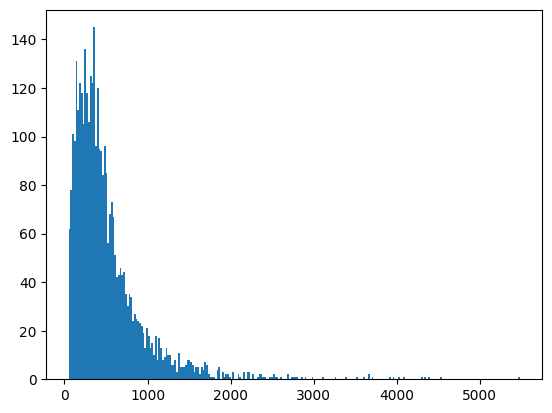

min protein length 50
max protein length 5478


In [ ]:
# Distribution on lengths
Lengths = []
for key in CVs.keys():
  cv = CVs[key]
  for prot in cv:
    Lengths += [prot["sequence"].__len__()]


plt.hist(Lengths, bins = 256)
plt.show()

print("min protein length", np.min(Lengths))
print("max protein length",np.max(Lengths))